In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from scipy import stats

In [ ]:
# Define the function to remove outliers based on IQR
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)].dropna()

In [ ]:
df_data = pd.read_excel('/content/merged.xlsx')
df_data

,Unnamed: 0,NINO3.4,swh
0,1950-01-01,24.55,0.626802
1,1950-02-01,25.06,0.732884
2,1950-03-01,25.87,0.844010
3,1950-04-01,26.28,1.219686
4,1950-05-01,26.18,1.466245
...,...,...,...
880,2023-05-01,28.40,1.365246
881,2023-06-01,28.57,1.709586
882,2023-07-01,28.32,2.060599
883,2023-08-01,28.21,1.928344


In [ ]:
# Convert 'Unnamed: 0' to datetime format
df_data['Unnamed: 0'] = pd.to_datetime(df_data['Unnamed: 0'])
df_data.set_index('Unnamed: 0', inplace=True)
df_data.sort_index(inplace=True)
df_data

,NINO3.4,swh
Unnamed: 0,,
1950-01-01,24.55,0.626802
1950-02-01,25.06,0.732884
1950-03-01,25.87,0.844010
1950-04-01,26.28,1.219686
1950-05-01,26.18,1.466245
...,...,...
2023-05-01,28.40,1.365246
2023-06-01,28.57,1.709586
2023-07-01,28.32,2.060599


In [ ]:
# Extract NINO3.4 index and significant wave height columns
nino_values = df_data['NINO3.4'].values.reshape(-1, 1)  # Reshape to 2D array
swh_values = df_data['swh'].values

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(nino_values, swh_values, test_size=0.2, random_state=42)

In [ ]:
# Verify the shapes of your training sets
# print(X_train.shape)  # Check the number of samples in X_train
# print(y_train.shape)  # Check the number of samples in y_train

In [ ]:
# s
X_train, X_test, y_train, y_test = train_test_split(nino_values, swh_values, test_size=0.2, random_state=42)

# Verify the shapes of your training sets
# print(X_train.shape)  # Check the number of samples in X_train
# print(y_train.shape)  # Check the number of samples in y_train

# Initialize the StandardScaler
scaler = StandardScaler()

# # Scale the features
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# Scale the features
X_train_scaledae = scaler.fit_transform(X_train)
X_test_scaledae = scaler.transform(X_test)

# Remove outliers based on IQR for training data
X_combined_train = np.column_stack((X_train_scaledae, y_train))
X_combined_iqr_train = remove_outliers_iqr(pd.DataFrame(X_combined_train, columns=['NINO3.4', 'swh'])).values
X_train_scaled = X_combined_iqr_train[:, :-1]
y_train_filtered = X_combined_iqr_train[:, -1]

# Remove outliers based on IQR for testing data
X_combined_test = np.column_stack((X_test_scaledae, y_test))
X_combined_iqr_test = remove_outliers_iqr(pd.DataFrame(X_combined_test, columns=['NINO3.4', 'swh'])).values
X_test_scaled = X_combined_iqr_test[:, :-1]
y_test_filtered = X_combined_iqr_test[:, -1]

In [ ]:
X = df_data[['NINO3.4']]  # X should be a DataFrame containing only the 'nino3.4' column
y = df_data['swh']  # y is a Series containing the 'swh' column

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=10)


# # Train the model
# rf_regressor.fit(X_train, y_train)

num_folds = 5  # You can adjust the number of folds based on your preference
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Make predictions on the test set
# predictions = rf_regressor.predict(X_test)

# Calculate the mean squared error
# mse = mean_squared_error(y_test, predictions)
# print(f'Mean Squared Error: {mse}')

mse_scores = cross_val_score(rf_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -mse_scores  # Convert negative MSE scores to positive values
mean_mse = mse_scores.mean()
print(f'Mean Squared Error (Cross-Validated): {mean_mse}')

Mean Squared Error (Cross-Validated): 0.2743453558542601


In [ ]:
# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=10)

# Train the model
gb_regressor.fit(X_train_scaled, y_train_filtered)

# Make predictions on the test set
predictions_gb = gb_regressor.predict(X_test_scaled)

# Calculate the mean squared error for Gradient Boosting
mse_gb = mean_squared_error(y_test_filtered, predictions_gb)
print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')

Mean Squared Error (Gradient Boosting): 0.32146277339210294


In [ ]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# Initialize the Support Vector Regressor
svr_regressor = SVR(kernel='rbf', C=10, epsilon=0.1)  # Radial basis function (RBF) kernel is commonly used for SVR

# Train the model
svr_regressor.fit(X_train_scaled, y_train_filtered)

# Make predictions on the test set
predictions_svr = svr_regressor.predict(X_test_scaled)

# Calculate the mean squared error
mse_svr = mean_squared_error(y_test_filtered, predictions_svr)
print(f'Mean Squared Error (SVR): {mse_svr}')

Mean Squared Error (SVR): 0.2915525621048605


In [ ]:
# Standardize the features (Neural networks are sensitive to feature scales)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Build the Neural Network model
model_one = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model_one.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_one.fit(X_train_scaled, y_train_filtered, epochs=1000, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model on the test set
mse_model_one = model_one.evaluate(X_test_scaled, y_test_filtered)
print(f'Mean Squared Error (Neural Network - Model One): {mse_model_one}')


Epoch 1/1000
10/10 [==============================] - 1s 26ms/step - loss: 2.2413 - val_loss: 1.6935
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 2.0069 - val_loss: 1.4992
Epoch 3/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.7973 - val_loss: 1.3258
Epoch 4/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.6088 - val_loss: 1.1708
Epoch 5/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.4406 - val_loss: 1.0316
Epoch 6/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.2839 - val_loss: 0.9095
Epoch 7/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.1459 - val_loss: 0.8004
Epoch 8/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.0205 - val_loss: 0.7041
Epoch 9/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.9078 - val_loss: 0.6203
Epoch 10/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.8088 - val_loss: 0.54

In [ ]:
# # Build a deeper Neural Network model

# model = keras.Sequential([
#     keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(1)  # Output layer with one neuron for regression
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.1, verbose=1)

# # Evaluate the model on the test set
# mse_model = model.evaluate(X_test_scaled, y_test)
# print(f'Mean Squared Error (Neural Network - Model): {mse_model}')

In [ ]:
# Calculate NSE for Random Forest
rf_regressor.fit(X_train_scaled, y_train)
predictions_rf = rf_regressor.predict(X_test_scaled)
nse_rf = 1 - (mean_squared_error(y_test_filtered, predictions_rf) / np.var(y_test_filtered))
print(f'NSE for Random Forest: {nse_rf}')

# Calculate NSE for Gradient Boosting
nse_gb = 1 - (mean_squared_error(y_test_filtered, predictions_gb) / np.var(y_test_filtered))
print(f'NSE for Gradient Boosting: {nse_gb}')

nse_svr = 1 - (mean_squared_error(y_test_filtered, predictions_svr) / np.var(y_test_filtered))
print(f'NSE for SVR: {nse_svr}')

# Calculate NSE for MLP
predictions_mlp = model_one.predict(X_test_scaled).flatten()

# Calculate NSE for MLP
nse_mlp = 1 - (mean_squared_error(y_test_filtered, predictions_mlp) / np.var(y_test_filtered))
print(f'NSE for MLP: {nse_mlp}')


NSE for Random Forest: -0.1739289640210413
NSE for Gradient Boosting: -0.16763851926116935
NSE for SVR: -0.05899665554021638
6/6 [==============================] - 0s 2ms/step
NSE for MLP: 0.023312295746599654


In [ ]:
# Make predictions on the test set
predictions_mlp = model_one.predict(X_test_scaled).flatten()

# Calculate correlation coefficient for MLP
correlation_mlp = np.corrcoef(y_test, predictions_mlp)[0, 1]
print(f'Correlation Coefficient for MLP: {correlation_mlp}')

# Make predictions on the test set
predictions_rf = rf_regressor.predict(X_test_scaled).flatten()

# Calculate correlation coefficient for Random Forest
correlation_rf = np.corrcoef(y_test, predictions_rf)[0, 1]
print(f'Correlation Coefficient for Random Forest: {correlation_rf}')

# Make predictions on the test set
predictions_svr = svr_regressor.predict(X_test_scaled)

# Calculate correlation coefficient for SVR
correlation_svr = np.corrcoef(y_test, predictions_svr)[0, 1]
print(f'Correlation Coefficient for SVR: {correlation_svr}')

# Make predictions on the test set
predictions_gb = gb_regressor.predict(X_test_scaled).flatten()

# Calculate correlation coefficient for Gradient Boosting
correlation_gb = np.corrcoef(y_test, predictions_gb)[0, 1]
print(f'Correlation Coefficient for Gradient Boosting: {correlation_gb}')



6/6 [==============================] - 0s 2ms/step


ValueError: ignored

In [ ]:
# Scatter plot for Neural Network - Model
predictions_model = model.predict(X_test_scaled).flatten()
plt.scatter(y_test, predictions_model, color='green', label='Actual vs. Predicted (Model)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Regression Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Regression Line (Neural Network - Model)')
plt.legend()
plt.show()

NameError: ignored

6/6 [==============================] - 0s 4ms/step


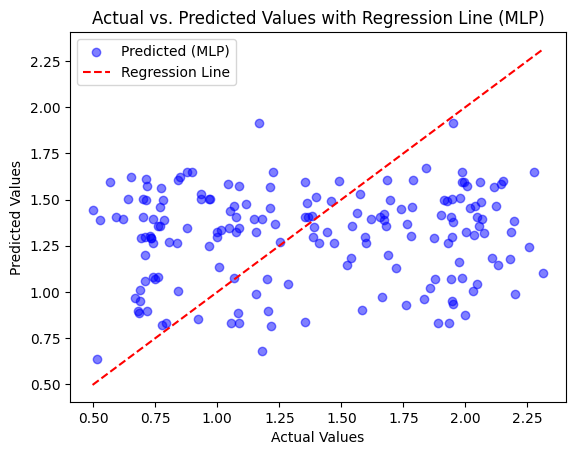

In [ ]:
# Ensure y_test and predictions_rf have the same size
predictions_mlp = model_one.predict(X_test_scaled).flatten()

# Create a scatter plot
plt.scatter(y_test_filtered, predictions_rf, color='blue', label='Predicted (MLP)', alpha=0.5)

# # Plot the regression line (identity line)
plt.plot([min(y_test_filtered), max(y_test_filtered)], [min(y_test_filtered), max(y_test_filtered)], linestyle='--', color='red', label='Regression Line')
# m, b = np.polyfit(X_test_scaled.ravel(), y_test, 1)
# plt.plot(X_test_scaled, m*x_test_scaled+b)
# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Regression Line (MLP)')

# Add a legend
plt.legend()

# Display the plot
plt.show()



6/6 [==============================] - 0s 2ms/step


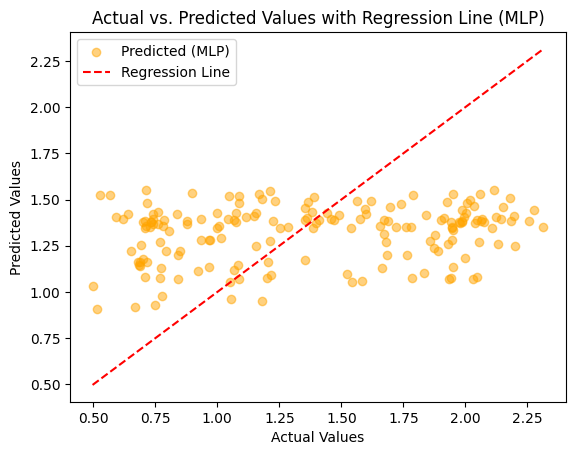

In [ ]:


# Make predictions on the test set
predictions_mlp = model_one.predict(X_test_scaled).flatten()

# Create a scatter plot
plt.scatter(y_test_filtered, predictions_mlp, color='orange', label='Predicted (MLP)', alpha=0.5)

# Plot the regression line (identity line)
plt.plot([min(y_test_filtered), max(y_test_filtered)], [min(y_test_filtered), max(y_test_filtered)], linestyle='--', color='red', label='Regression Line')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Regression Line (MLP)')

# Add a legend
plt.legend()

# Display the plot
plt.show()

6/6 [==============================] - 0s 2ms/step


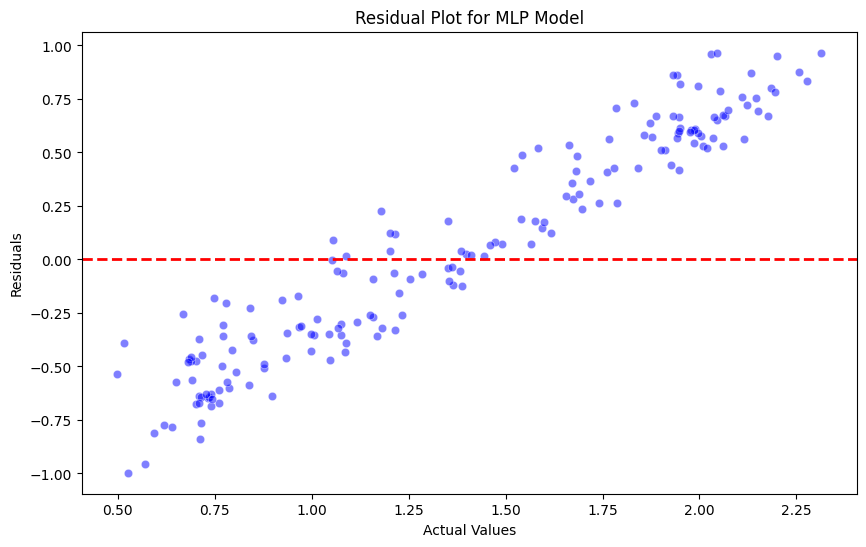

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
predictions_mlp = model_one.predict(X_test_scaled).flatten()

# Calculate residuals
residuals = y_test_filtered - predictions_mlp

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_filtered, y=residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot for MLP Model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


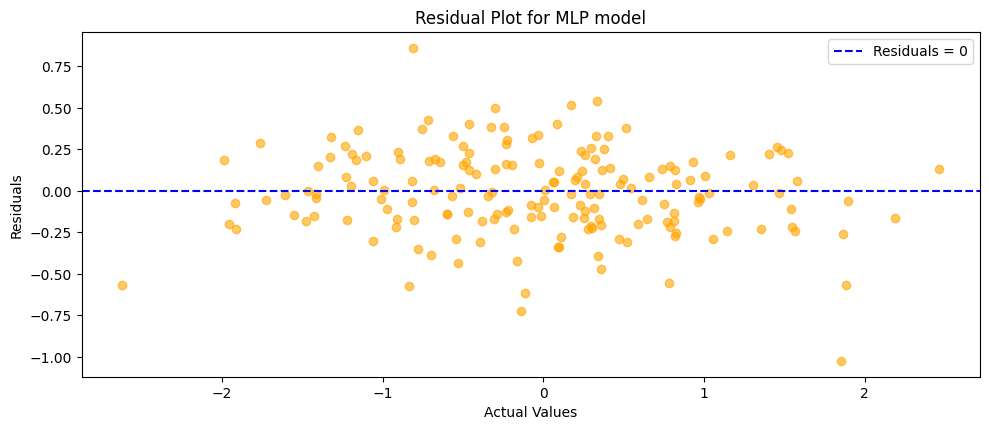

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Generate synthetic data
np.random.seed(42)
actual_values = np.random.normal(0, 1, 178)  # Assume actual values are normally distributed
predicted_values = actual_values + np.random.normal(0, 0.26629042625427246, 178)  # Add noise

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting
plt.figure(figsize=(10, 8))

# Residual plot
plt.subplot(2, 1, 2)
plt.scatter(actual_values, residuals, color='orange', alpha=0.6)
plt.axhline(y=0, linestyle='--', color='blue', label='Residuals = 0')
plt.title('Residual Plot for MLP model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()
